<h1>Table of Contents<span class="tocSkip"></span></h1>

<div class="toc"><ul class="toc-item"><li><span><a href="#EDA and Feature Engineering" data-toc-modified-id="EDA and Feature Engineering"><span class="toc-item-num"></span>EDA and Feature Engineering</a></span></li>
 <li><span><a href="#Heat Map" data-toc-modified-id="Heat Map"><span class="toc-item-num"></span>Heat Map</a></span></li>
 <li><span><a href="#One Hot Encoding" data-toc-modified-id="One Hot Encoding"><span class="toc-item-num"></span>One Hot Encoding</a></span></li>
 <li><span><a href="#XGBoost" data-toc-modified-id="XGBoost"><span class="toc-item-num"></span>XGBoost</a></span></li>
 <li><span><a href="#LightGBM" data-toc-modified-id="LightGBM"><span class="toc-item-num"></span>LightGBM</a></span></li>
 <li><span><a href="#Random Forest" data-toc-modified-id="Random Forest"><span class="toc-item-num"></span>Random Forest</a></span></li>
 <li><span><a href="#Submission file preparation" data-toc-modified-id="Submission file preparation"><span class="toc-item-num"></span>Submission file preparation</a></span></li>

In [1]:
import os       # provides link between python code and Operating System on which code is running
import pickle   # this makes it easy to serialize the models into files  for deployment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns
import datetime 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb

In [2]:
os.getcwd()

'C:\\Users\\198353'

In [3]:
path = (r'C:\Users\198353\Downloads\Women Hack')
train_data = pd.read_csv(path + r'\train.csv')
test_data = pd.read_csv( path + r'\test.csv') 

In [4]:
train = train_data.copy()
test = test_data.copy()

In [5]:
print(train.shape,test.shape)

(512087, 11) (36000, 9)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 11 columns):
ID                    512087 non-null int64
Day_No                512087 non-null int64
Course_ID             512087 non-null int64
Course_Domain         512087 non-null object
Course_Type           512087 non-null object
Short_Promotion       512087 non-null int64
Public_Holiday        512087 non-null int64
Long_Promotion        512087 non-null int64
User_Traffic          512087 non-null int64
Competition_Metric    510323 non-null float64
Sales                 512087 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 43.0+ MB


In [7]:
train.head(3)

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,3,1,Development,Course,0,0,1,11655,0.007,75


In [8]:
test.head(3)

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric
0,883,883,1,Development,Course,1,0,1,0.007
1,884,884,1,Development,Course,1,0,1,0.007
2,885,885,1,Development,Course,1,0,1,0.007


### EDA and Feature Engineering

In [53]:
import pandas_profiling
pandas_profiling.ProfileReport(train)

Number of variables,10
Number of observations,512087
Total Missing (%),0.0%
Total size in memory,39.1 MiB
Average record size in memory,80.0 B
Numeric,5
Categorical,2
Boolean,3
Date,0
Text (Unique),0
Rejected,0


In [9]:
def descriptive(df):
    eda_data = pd.DataFrame({'Column': [i for i in df.columns],
                 'Null Count': df.isnull().sum().values,
                 'Percentage':((df.isnull().sum().values/len(df))*100).round(2),
                 'Unique Values': df.nunique().values        }) 
    return (eda_data)

In [10]:
def datatype_split(df):
    df_categorical = df.select_dtypes(exclude= np.number)
    df_numerical = df.select_dtypes(include= np.number)
    print (df_categorical.shape, df_numerical.shape)
    print('\nCategorical Columns \n',df_categorical.columns)
    print('\n Numerical Columns \n',df_numerical.columns) 
    return df_categorical,df_numerical

In [11]:
descriptive(train)

,Column,Null Count,Percentage,Unique Values
0,ID,0,0.00,512087
1,Day_No,0,0.00,882
2,Course_ID,0,0.00,600
3,Course_Domain,0,0.00,4
4,Course_Type,0,0.00,3
5,Short_Promotion,0,0.00,2
6,Public_Holiday,0,0.00,2
7,Long_Promotion,0,0.00,2
8,User_Traffic,0,0.00,3475
9,Competition_Metric,1764,0.34,196


In [12]:
train_categorical, train_numerical = datatype_split(train)

(512087, 2) (512087, 9)

Categorical Columns 
 Index(['Course_Domain', 'Course_Type'], dtype='object')

 Numerical Columns 
 Index(['ID', 'Day_No', 'Course_ID', 'Short_Promotion', 'Public_Holiday',
       'Long_Promotion', 'User_Traffic', 'Competition_Metric', 'Sales'],
      dtype='object')


In [13]:
pd.DataFrame({'Column': [i for i in train_numerical.columns],
               'Skewness':train_numerical.skew().values,
                 'Kurtosis': train_numerical.kurt().values}) 

,Column,Skewness,Kurtosis
0,ID,0.000167,-1.199982
1,Day_No,0.058609,-1.196019
2,Course_ID,0.002538,-1.199726
3,Short_Promotion,0.493386,-1.756577
4,Public_Holiday,5.351565,26.639351
5,Long_Promotion,0.044140,-1.998059
6,User_Traffic,2.307822,9.417370
7,Competition_Metric,2.577967,8.780057
8,Sales,1.374770,3.609506


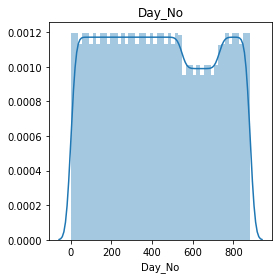

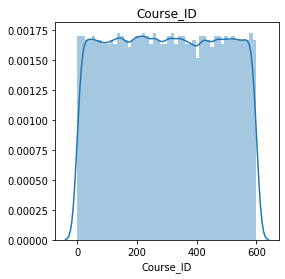

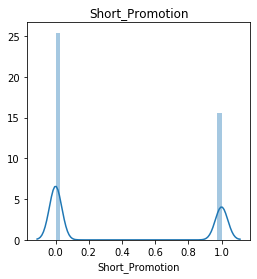

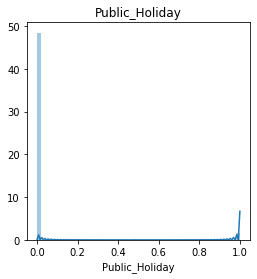

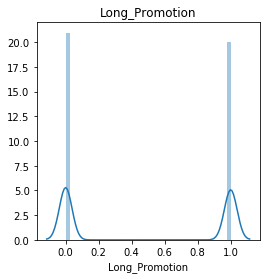

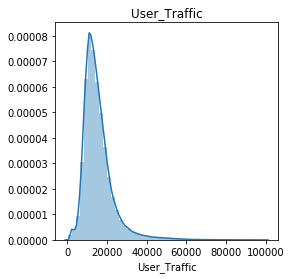

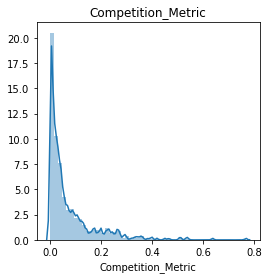

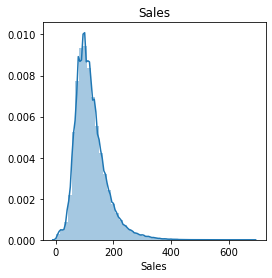

In [15]:
# Distribution plot of all the numerical columns

## User_Traffic,Competition_Metric, Sales are right skewed 

for i in train_numerical.columns:
    fig = plt.figure(figsize = (4,4))
    sns.distplot(train_numerical[i])
    plt.title(i)
    plt.show()

In [14]:
train.columns

Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Sales'],
      dtype='object')

In [20]:
boxplot_cols = ['Course_Domain', 'Course_Type','Short_Promotion', 'Public_Holiday', 'Long_Promotion']

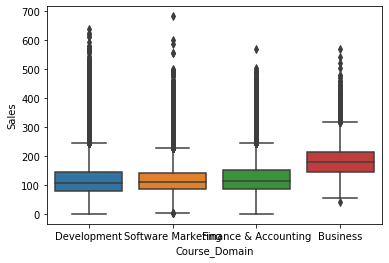

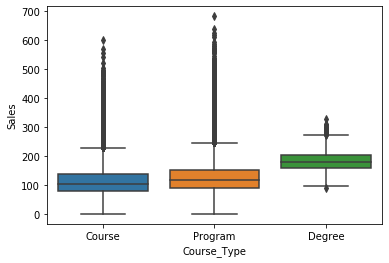

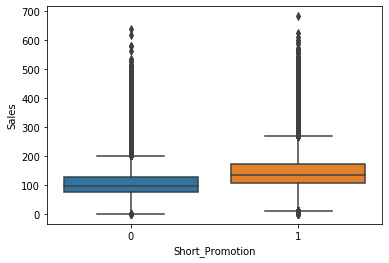

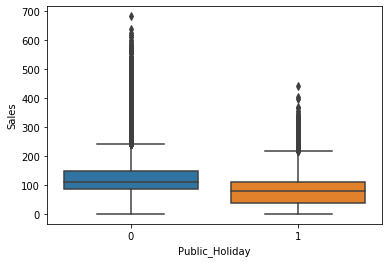

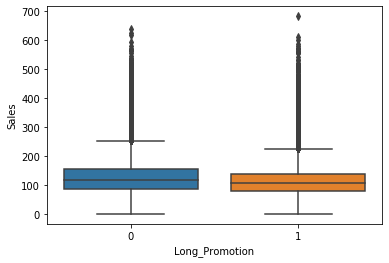

In [25]:
for cols in boxplot_cols:
    sns.boxplot(x= cols, y = 'Sales' , data = train)
    plt.show() 
    
# Sales are little lower on holidays

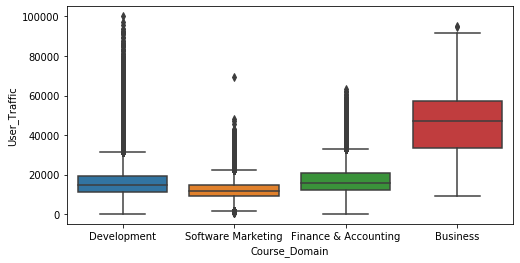

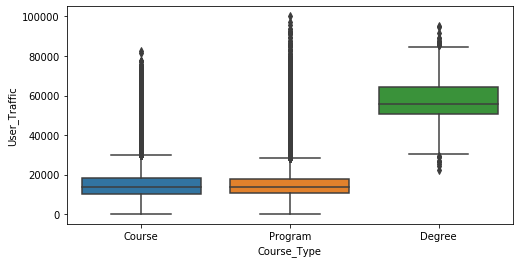

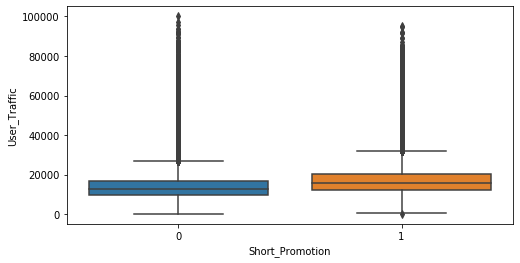

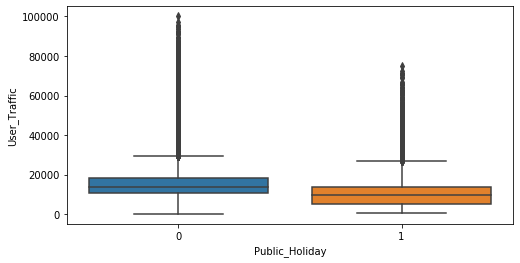

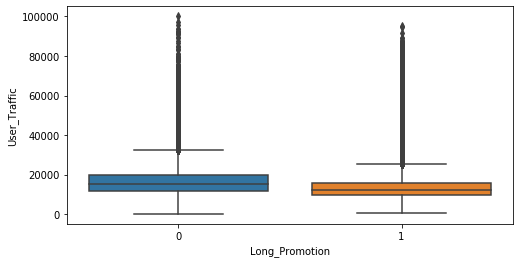

In [26]:
for cols in boxplot_cols:
    plt.figure(figsize = (8,4))
    sns.boxplot(x= cols, y = 'User_Traffic' , data = train)
    plt.show()
    
# User_Traffic is pretty high for Business, Degree

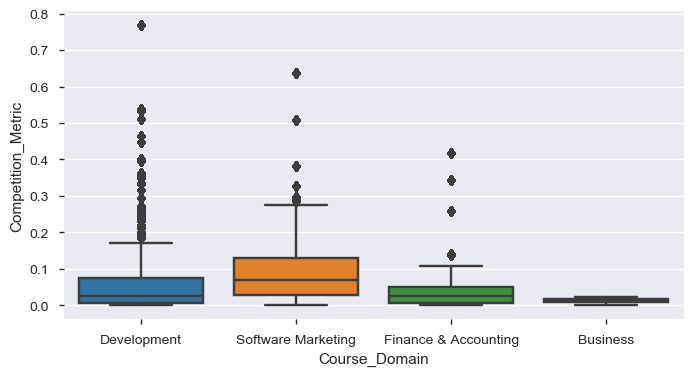

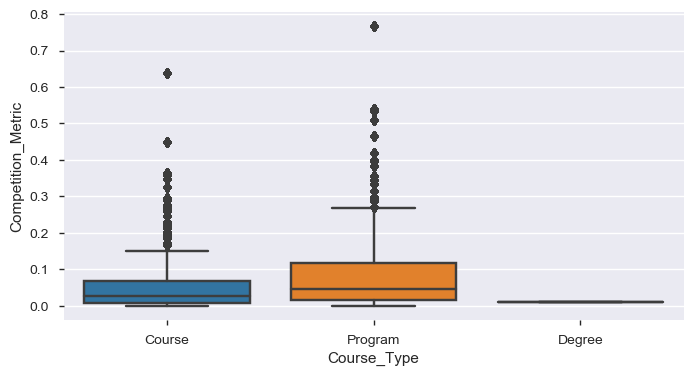

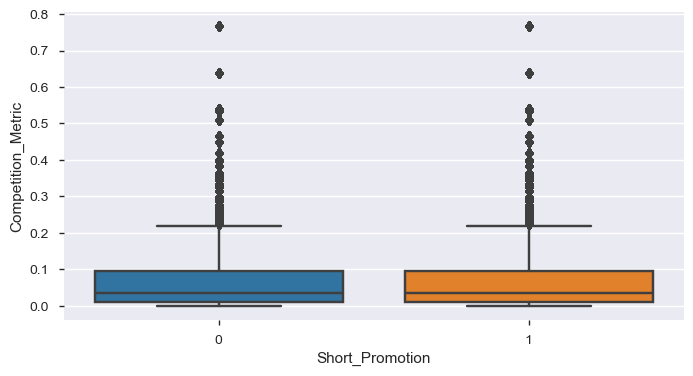

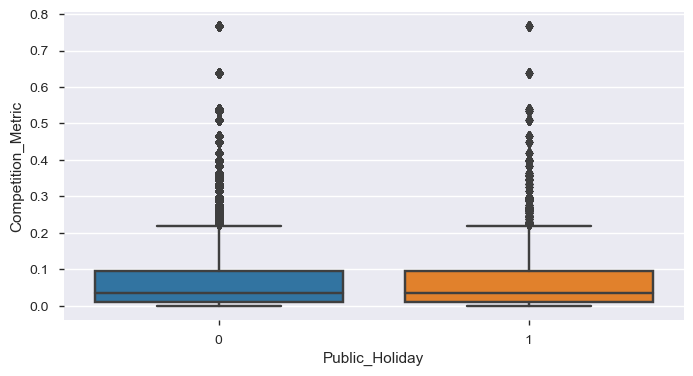

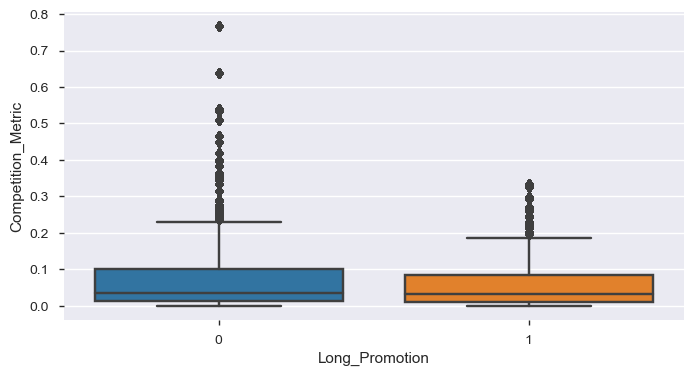

In [108]:
for cols in boxplot_cols:
    plt.figure(figsize = (8,4))
    sns.boxplot(x= cols, y = 'Competition_Metric' , data = train)
    plt.show()

In test dataset, User_Traffic is missing. In the current approach, that feature is being dropped. 

In [15]:
train.drop(columns = ['User_Traffic'],inplace = True)

In [16]:
def day_to_date(dataset):
    start = datetime.date(2016,12,31)
    dataset['Date'] = dataset['Day_No'].apply(lambda x: start + datetime.timedelta(x)) 
    
def day_month_year(dataset): 
    dataset['Day'] = dataset['Date'].apply(lambda x: x.day)
    dataset['Month'] = dataset['Date'].apply(lambda x: x.month)
    dataset['Year'] = dataset['Date'].apply(lambda x: x.year)

In [17]:
def data_prep(df):
    day_to_date(df)
    day_month_year(df)
    df.drop(columns = ['ID','Date'],inplace = True)
    df['Competition_Metric'] = df['Competition_Metric'].round(3)
    df['Competition_Metric'].fillna(df['Competition_Metric'].mode()[0], inplace = True)
    return df

In [18]:
train = data_prep(train)
train.head(3)

,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day,Month,Year
0,1,1,Development,Course,0,1,1,0.007,81,1,1,2017
1,2,1,Development,Course,0,0,1,0.007,79,2,1,2017
2,3,1,Development,Course,0,0,1,0.007,75,3,1,2017


The Competition_Metric is having a lot of high decimal quantites, hence rounding off to 3 decimal places

In [19]:
train[train['Competition_Metric'] == 0]['Course_ID'].value_counts()

300    882
274    882
393    882
353    882
17     882
544    882
424    882
408    882
304    882
530    881
Name: Course_ID, dtype: int64

In [18]:
train[train['Sales']==0].shape  ## 14 rows have 0 sales

(14, 9)

In [27]:
pd.crosstab(train['Course_Domain'],train['Course_Type'])

Course_Type,Course,Degree,Program
Course_Domain,,,
Business,2646,1764,0
Development,158163,0,106132
Finance & Accounting,40020,0,37190
Software Marketing,61918,0,104254


In [28]:
600*882    # total this many values should have been there

529200

#### There are some Course_IDs which have data for only 698 days

In [152]:
train['Course_ID'].value_counts()[train['Course_ID'].value_counts() == 698].index.sort_values()

Int64Index([  9,  14,  29,  33,  41,  43,  59,  62,  66,  75,  78,  85,  87,
             91,  97,  99, 104, 110, 111, 121, 128, 131, 146, 158, 166, 169,
            171, 174, 175, 181, 187, 204, 212, 237, 241, 245, 248, 265, 275,
            278, 283, 287, 289, 290, 299, 312, 325, 327, 329, 348, 349, 362,
            363, 371, 376, 379, 382, 386, 395, 398, 399, 401, 402, 403, 404,
            407, 417, 432, 435, 436, 449, 450, 453, 456, 458, 474, 484, 488,
            490, 499, 511, 514, 524, 531, 540, 545, 551, 555, 560, 570, 576,
            592, 595],
           dtype='int64')

In [153]:
train[train['Public_Holiday'] == 1]['Day_No'].unique()

array([  1,  88,  91, 121, 129, 140, 276, 304, 359, 360, 366, 473, 476,
       486, 514, 525, 641, 669, 724, 725, 823, 826, 851, 864, 875, 150,
       305, 535, 670, 731,   6, 227, 371, 736, 324, 688], dtype=int64)

In [37]:
train[train['Competition_Metric'].isna()]['Course_ID']  # 176 and 354 CourseIDs have missing Competition_Metric

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric
10500,160397,883,176,Software Marketing,Course,1,0,0,NaN
10501,160398,884,176,Software Marketing,Course,1,0,0,NaN
10502,160399,885,176,Software Marketing,Course,1,1,0,NaN
10503,160400,886,176,Software Marketing,Course,1,0,0,NaN
10504,160401,887,176,Software Marketing,Course,0,0,0,NaN
10505,160402,888,176,Software Marketing,Course,0,0,0,NaN
10506,160403,889,176,Software Marketing,Course,0,0,0,NaN
10507,160404,890,176,Software Marketing,Course,0,0,0,NaN
10508,160405,891,176,Software Marketing,Course,0,0,0,NaN
10509,160406,892,176,Software Marketing,Course,0,0,0,NaN


In [53]:
print(sorted(train['Competition_Metric'].unique()))     ## sorting method for unique values

[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.027, 0.028, 0.029, 0.03, 0.032, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.049, 0.051, 0.054, 0.055, 0.056, 0.057, 0.059, 0.06, 0.061, 0.064, 0.068, 0.074, 0.075, 0.076, 0.082, 0.084, 0.087, 0.09, 0.092, 0.097, 0.099, 0.101, 0.104, 0.112, 0.114, 0.116, 0.122, 0.129, 0.141, 0.142, 0.155, 0.166, 0.172, 0.178, 0.182, 0.186, 0.193, 0.198, 0.199, 0.202, 0.213, 0.214, 0.218, 0.22, 0.229, 0.237, 0.255, 0.263, 0.267, 0.294, 0.295, 0.297, 0.316, 0.334, 0.4, 0.419, 0.768, nan, 0.011, 0.025, 0.026, 0.031, 0.033, 0.04, 0.05, 0.052, 0.053, 0.058, 0.062, 0.066, 0.067, 0.069, 0.07, 0.071, 0.072, 0.077, 0.078, 0.083, 0.085, 0.086, 0.091, 0.094, 0.095, 0.096, 0.098, 0.103, 0.105, 0.106, 0.107, 0.108, 0.109, 0.11, 0.111, 0.117, 0.119, 0.121, 0.123, 0.124, 0.126, 0.127, 0.13, 0.133, 0.136, 0

In [54]:
train['Competition_Metric'].mode()

0    0.001
dtype: float64

In [56]:
train['Competition_Metric'].mean()

0.07334506577204686

In [63]:
train[train['Competition_Metric'] < 0.25]['Competition_Metric'].mode()

0    0.001
dtype: float64

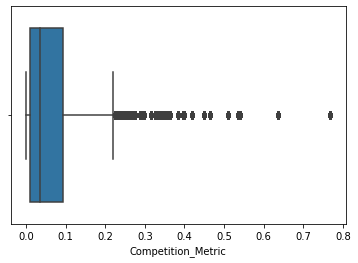

In [59]:
sns.boxplot(train['Competition_Metric'])

In [53]:
train.isnull().sum()

Day_No                0
Course_ID             0
Course_Domain         0
Course_Type           0
Short_Promotion       0
Public_Holiday        0
Long_Promotion        0
Competition_Metric    0
Sales                 0
Day                   0
Month                 0
Year                  0
dtype: int64

In [55]:
# train.head(3)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 12 columns):
Day_No                512087 non-null int64
Course_ID             512087 non-null int64
Course_Domain         512087 non-null object
Course_Type           512087 non-null object
Short_Promotion       512087 non-null int64
Public_Holiday        512087 non-null int64
Long_Promotion        512087 non-null int64
Competition_Metric    512087 non-null float64
Sales                 512087 non-null int64
Day                   512087 non-null int64
Month                 512087 non-null int64
Year                  512087 non-null int64
dtypes: float64(1), int64(9), object(2)
memory usage: 46.9+ MB


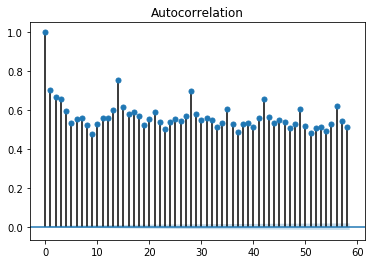

In [113]:
''''
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train['Sales'])
pyplot.show()
# plot_pacf(['Sales'], lags= 20)

'''

In [115]:
'''
train['Sales_lag'] = train['Sales'].shift(14)
train.head(17)   ## including a lag of 14 days
'''

,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Sales_lag
0,1,1,Development,Course,0,1,1,0.007,81,NaN
1,2,1,Development,Course,0,0,1,0.007,79,NaN
2,3,1,Development,Course,0,0,1,0.007,75,NaN
3,4,1,Development,Course,0,0,1,0.007,80,NaN
4,5,1,Development,Course,0,0,1,0.007,41,NaN
5,6,1,Development,Course,0,0,1,0.007,62,NaN
6,7,1,Development,Course,1,0,1,0.007,122,NaN
7,8,1,Development,Course,1,0,1,0.007,114,NaN
8,9,1,Development,Course,1,0,1,0.007,121,NaN
9,10,1,Development,Course,1,0,1,0.007,100,NaN


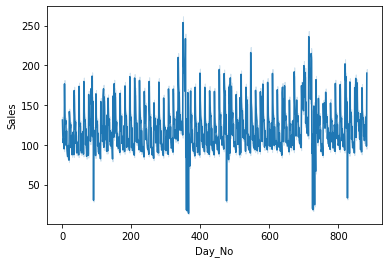

In [28]:
sns.lineplot(x="Day_No", y="Sales", data= train)

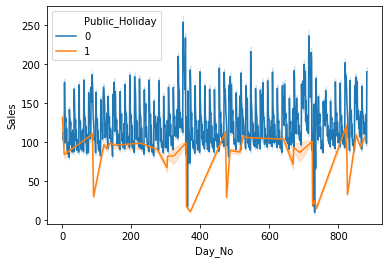

In [29]:
sns.lineplot(x="Day_No", y="Sales",hue = 'Public_Holiday', data= train)

In [31]:
def course_lineplot( id_no ):
    plot_df = train[train['Course_ID'] == id_no]
    plt.figure (figsize = (15,4))
    sns.lineplot(x = 'Day_No',y = 'User_Traffic', data = plot_df)
    plt.show()
    plt.figure (figsize = (15,4))
    sns.lineplot(x = 'Day_No',y = 'Sales', data = plot_df )
    plt.show() 
    
    boxplot_cols = ['Course_Domain', 'Course_Type','Short_Promotion', 'Public_Holiday', 'Long_Promotion']
    for cols in boxplot_cols:
        plt.figure(figsize = (8,4))
        sns.boxplot(x= cols, y = 'Sales' , data = plot_df)
        plt.show()
        plt.figure(figsize = (8,4))
        sns.boxplot(x= cols, y = 'User_Traffic' , data = plot_df)
        plt.show()
        plt.figure(figsize = (8,4))
        sns.boxplot(x= cols, y = 'Competition_Metric' , data = plot_df)
        plt.show()

Missing data from 450 to 700 leading to total 698 values only

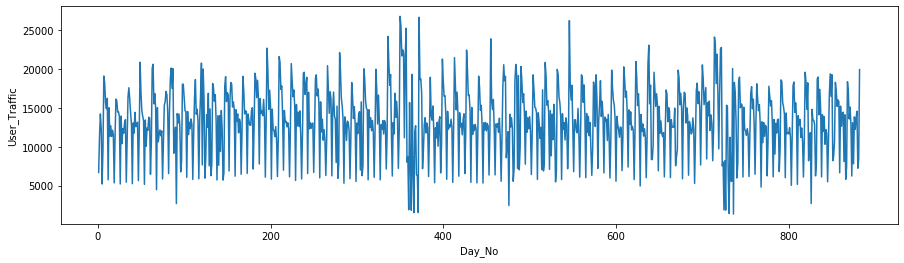

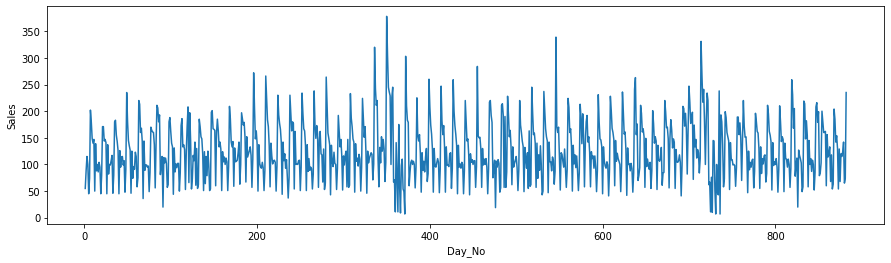

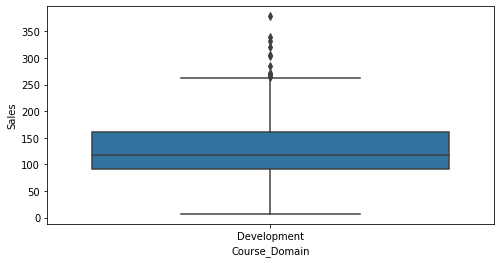

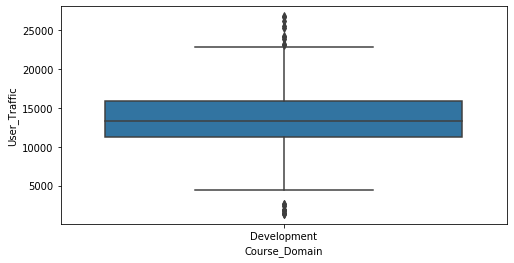

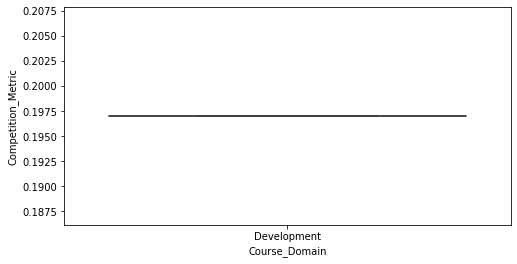

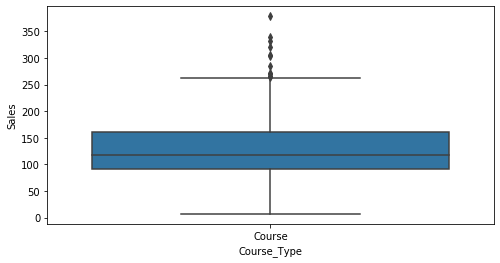

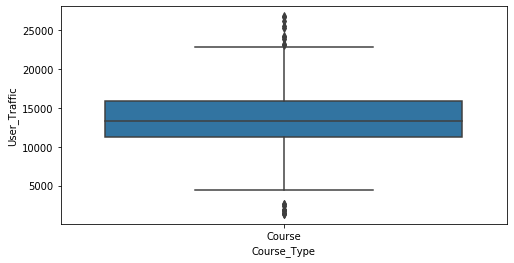

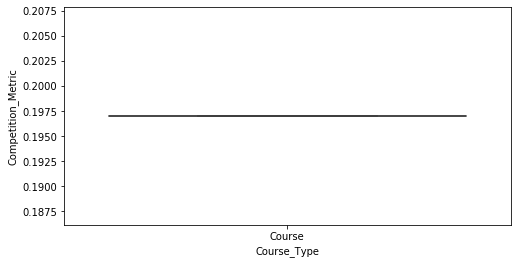

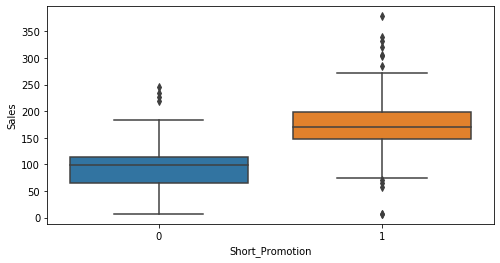

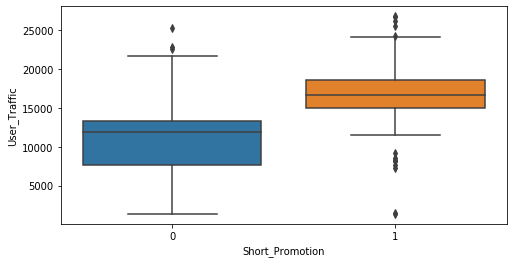

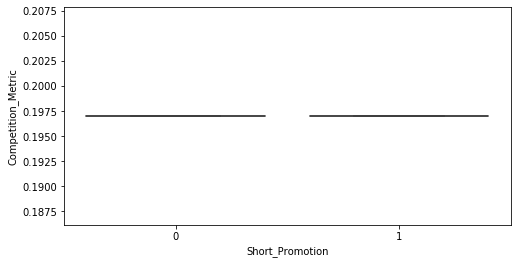

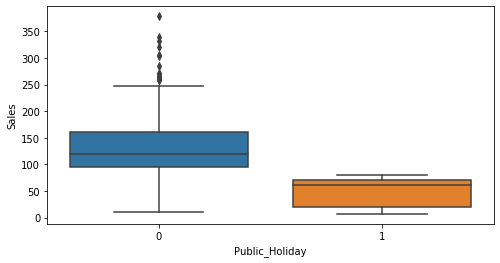

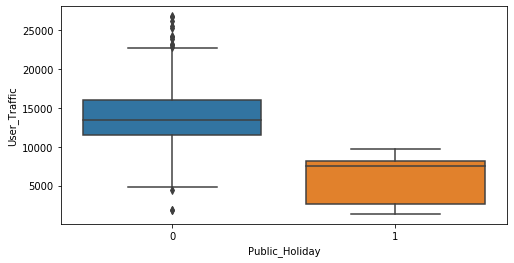

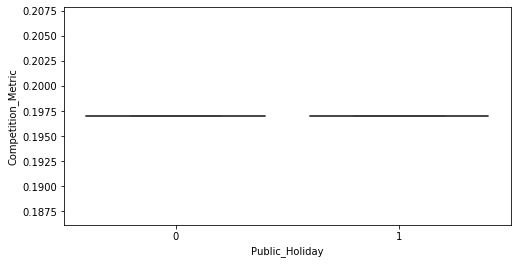

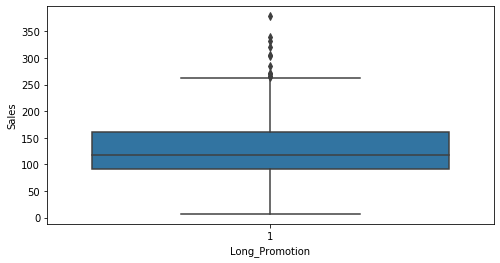

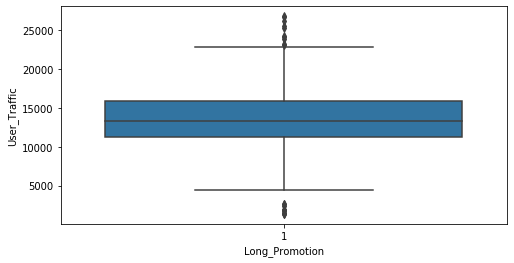

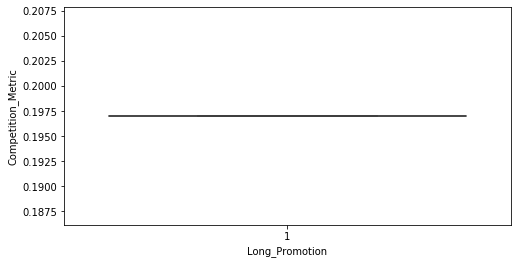

In [32]:
course_lineplot(286)

# For Course_ID 9, short promotion is helpful is sales and user_traffic whereas both decrease on public holidays


### Heat Map

In [20]:
corr = train.corr()

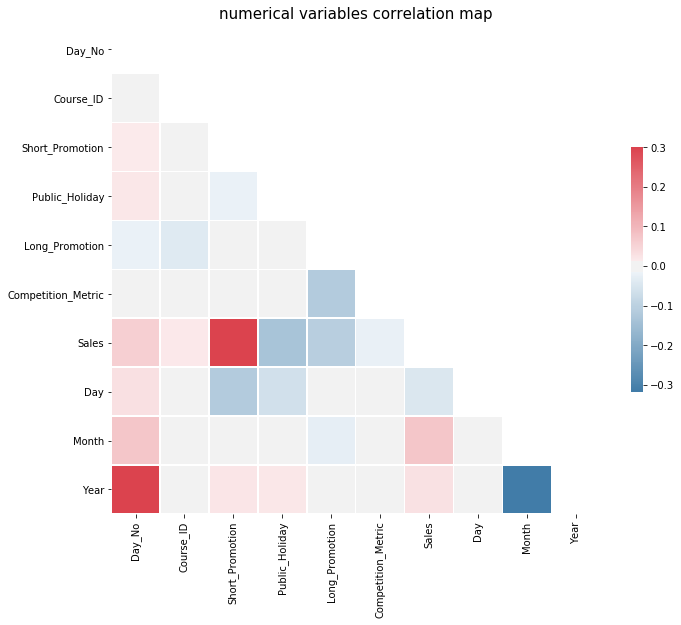

In [21]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap= cmap , vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("numerical variables correlation map", fontsize=15)
plt.show()

In [66]:
# train1 =  train.drop(columns = ['User_Traffic'])
# train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 9 columns):
Day_No                512087 non-null int64
Course_ID             512087 non-null int64
Course_Domain         512087 non-null object
Course_Type           512087 non-null object
Short_Promotion       512087 non-null int64
Public_Holiday        512087 non-null int64
Long_Promotion        512087 non-null int64
Competition_Metric    512087 non-null float64
Sales                 512087 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 35.2+ MB


### One Hot Encoding 

In [22]:
train1 = pd.get_dummies(train, columns=['Course_Domain','Course_Type'], prefix_sep='_')

In [23]:
train1.head(3)

,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Sales,Day,Month,Year,Course_Domain_Business,Course_Domain_Development,Course_Domain_Finance & Accounting,Course_Domain_Software Marketing,Course_Type_Course,Course_Type_Degree,Course_Type_Program
0,1,1,0,1,1,0.007,81,1,1,2017,0,1,0,0,1,0,0
1,2,1,0,0,1,0.007,79,2,1,2017,0,1,0,0,1,0,0
2,3,1,0,0,1,0.007,75,3,1,2017,0,1,0,0,1,0,0


In [24]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 17 columns):
Day_No                                512087 non-null int64
Course_ID                             512087 non-null int64
Short_Promotion                       512087 non-null int64
Public_Holiday                        512087 non-null int64
Long_Promotion                        512087 non-null int64
Competition_Metric                    512087 non-null float64
Sales                                 512087 non-null int64
Day                                   512087 non-null int64
Month                                 512087 non-null int64
Year                                  512087 non-null int64
Course_Domain_Business                512087 non-null uint8
Course_Domain_Development             512087 non-null uint8
Course_Domain_Finance & Accounting    512087 non-null uint8
Course_Domain_Software Marketing      512087 non-null uint8
Course_Type_Course                    512087 no

In [25]:
target_col = 'Sales'
x = train1.loc[:,train1.columns != target_col]
y = train1.loc[:,target_col]

In [26]:
train1[train1['Sales'] == 0].shape

(14, 17)

In [27]:
def train_test_split_func(x,y, test_size = 0.3):
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= test_size, random_state = 10) 
    print("xtrain",xtrain.shape)
    print("xtrest",xtest.shape)
    print("ytrain",ytrain.shape)
    print("ytest",ytest.shape)
    return xtrain,xtest,ytrain,ytest

xtrain, xtest, ytrain, ytest  = train_test_split_func(x,y)

xtrain (358460, 16)
xtrest (153627, 16)
ytrain (358460,)
ytest (153627,)


In [28]:
xtrain.head(3)

,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric,Day,Month,Year,Course_Domain_Business,Course_Domain_Development,Course_Domain_Finance & Accounting,Course_Domain_Software Marketing,Course_Type_Course,Course_Type_Degree,Course_Type_Program
307678,425,360,0,0,0,0.044,1,3,2018,0,1,0,0,1,0,0
247328,343,290,0,0,0,0.021,9,12,2017,0,1,0,0,0,0,1
260792,63,306,1,0,0,0.024,4,3,2017,0,0,0,1,0,0,1


In [29]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358460 entries, 307678 to 345353
Data columns (total 16 columns):
Day_No                                358460 non-null int64
Course_ID                             358460 non-null int64
Short_Promotion                       358460 non-null int64
Public_Holiday                        358460 non-null int64
Long_Promotion                        358460 non-null int64
Competition_Metric                    358460 non-null float64
Day                                   358460 non-null int64
Month                                 358460 non-null int64
Year                                  358460 non-null int64
Course_Domain_Business                358460 non-null uint8
Course_Domain_Development             358460 non-null uint8
Course_Domain_Finance & Accounting    358460 non-null uint8
Course_Domain_Software Marketing      358460 non-null uint8
Course_Type_Course                    358460 non-null uint8
Course_Type_Degree                    3584

In [101]:
## function for xgb hyperparameter tuning 

'''
def gridcv_xgb():
    objective = "reg:linear"
    seed = 100
    n_estimators = 500
    learning_rate = 0.1
    gamma = 0
    subsample = 0.75
    colsample_bytree = 0.6
    reg_alpha = 1
    reg_lambda = 1
    silent = False
    
    parameters = {}
    parameters['objective'] = objective
    parameters['seed'] = seed
    parameters['n_estimators'] = n_estimators
    parameters['learning_rate'] = learning_rate
    parameters['gamma'] = gamma
    parameters['colsample_bytree'] = colsample_bytree
    parameters['reg_alpha'] = reg_alpha
    parameters['reg_lambda'] = reg_lambda
    parameters['silent'] = silent
    
    scores = []
    
    cv_params = {# 'max_depth': [2,4,6,8,10],
                 # 'min_child_weight': [1,3,5,7],
                 # 'min_samples_split' : np.arange(2, 7, 1)
                 # 'n_estimators': 400,
                 #'learning_rate': np.arange(0.08, 0.1, 0.01),
                 # 'colsample_bytree' :np.arange(0.1, 1, 0.1)
            }
    
    gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                    
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True)
    
    gbm.fit(xtrain,ytrain)
    print(gbm.cv_results_)
    print("\n Best parameters %s" %gbm.best_params_)
    print("\n Best score %s" %gbm.best_score_)
    
    xgbr = xgb.XGBRegressor( learning_rate= 0.1, 
                        n_estimators= 400, 
                        silent=True, 
                        objective='reg:linear')
    
    xgbr.fit(xtrain,np.log1p(ytrain), eval_metric='rmse', verbose = False, early_stopping_rounds=10)
    return xgbr

model = gridcv_xgb()

'''

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:31:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:32:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:34:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:35:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:36:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:37:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:39:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:40:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:42:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 11.8min finished
C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:43:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'mean_fit_time': array([56.93146305, 83.68420568]), 'std_fit_time': array([2.92402923, 5.07294282]), 'mean_score_time': array([0.57415695, 0.72291322]), 'std_score_time': array([0.07791765, 0.01810986]), 'param_n_estimators': masked_array(data=[300, 400],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 300}, {'n_estimators': 400}], 'split0_test_score': array([-239.07763758, -208.91712759]), 'split1_test_score': array([-247.54992106, -219.61947522]), 'split2_test_score': array([-245.31275903, -215.66617369]), 'split3_test_score': array([-238.58600437, -209.50537192]), 'split4_test_score': array([-245.50026372, -216.53302309]), 'mean_test_score': array([-243.20531715, -214.04823431]), 'std_test_score': array([3.6594935 , 4.16644893]), 'rank_test_score': array([2,

IndexError: list index out of range

### XGBoost

In [78]:
#xgb

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)


cv_score =[]
i=1
for train_index,test_index in kf.split(x, y):
    print('Fold no. = ', i)
    
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #model
    xgb = xgb.XGBRegressor(n_estimators= 500)
    xgb.fit(x_train, y_train)
    y_pred= xgb.predict(x_test)
    score = rmsle(y_test, y_pred)
    print('RMSLE score:',score)
    cv_score.append(score)    
    
    i+=1

C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fold no. =  1


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

In [ ]:
#xgb mean rmsle
np.mean(cv_score)

### LightGBM

In [30]:
def rmsle(prediction, ytest):                        
    return np.sqrt(np.mean(np.square(np.log1p(prediction) - np.log1p(ytest))))

In [31]:
lgbr = lgb.LGBMRegressor(learning_rate=0.05, n_estimators = 1000)

In [32]:
lgb_model = lgbr.fit(xtrain, np.log1p(ytrain))

In [33]:
prediction_lgb = np.round(np.expm1(lgb_model.predict(xtest)))   # checking on the validation data
print(1000 * rmsle(prediction_lgb, ytest))

166.51850403569392


In [80]:
#lgbm
cv_score =[]
i=1 
for train_index,test_index in kf.split(x, y):
    print('Fold no. = ', i)
    
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #model
    lgbm = lgb.LGBMRegressor(n_estimators= 500 )
    lgbm.fit(x_train, y_train)
    y_pred= lgbm.predict(x_test)
    score = rmsle(y_pred, y_test)
    print('RMSLE score:',score)
    cv_score.append(score)    
    
    i+=1

C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fold no. =  1


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


RMSLE score: 0.1884975238664682
Fold no. =  2
RMSLE score: 0.18979661985553656
Fold no. =  3
RMSLE score: 0.1907775494308579
Fold no. =  4
RMSLE score: 0.19364607182093188
Fold no. =  5
RMSLE score: 0.19215644576508972


In [81]:
#lgbm mean rmsle
np.mean(cv_score)

0.19097484214777685

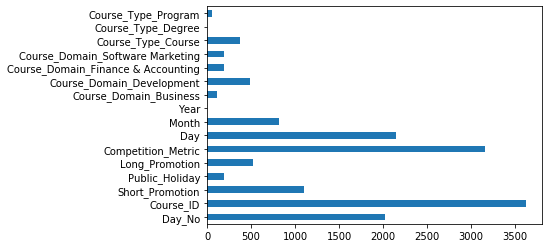

In [83]:
# lgbm feature importances
feat_importances = pd.Series(lgbm.feature_importances_, index= x.columns)
feat_importances.plot(kind='barh')

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestRegressor(n_estimators = 20, random_state = 0)
rf.fit(xtrain, np.log1p(ytrain))
prediction_rf = np.round(np.expm1(rf.predict(xtest)))   # checking on the validation data
print(1000 * rmsle(prediction_rf, ytest))

218.03311572928132


In [43]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = xtrain.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Course_ID,0.234381
Competition_Metric,0.187844
Short_Promotion,0.138291
Day_No,0.126180
Day,0.094589
Month,0.070518
Public_Holiday,0.052434
Long_Promotion,0.022895
Course_Type_Course,0.021795
Course_Domain_Development,0.018188


## Submission file preparation

In [73]:
data_prep(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 11 columns):
Day_No                36000 non-null int64
Course_ID             36000 non-null int64
Course_Domain         36000 non-null object
Course_Type           36000 non-null object
Short_Promotion       36000 non-null int64
Public_Holiday        36000 non-null int64
Long_Promotion        36000 non-null int64
Competition_Metric    36000 non-null float64
Day                   36000 non-null int64
Month                 36000 non-null int64
Year                  36000 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 3.0+ MB


In [74]:
test = pd.get_dummies(test, columns=['Course_Domain','Course_Type'], prefix_sep='_')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 16 columns):
Day_No                                36000 non-null int64
Course_ID                             36000 non-null int64
Short_Promotion                       36000 non-null int64
Public_Holiday                        36000 non-null int64
Long_Promotion                        36000 non-null int64
Competition_Metric                    36000 non-null float64
Day                                   36000 non-null int64
Month                                 36000 non-null int64
Year                                  36000 non-null int64
Course_Domain_Business                36000 non-null uint8
Course_Domain_Development             36000 non-null uint8
Course_Domain_Finance & Accounting    36000 non-null uint8
Course_Domain_Software Marketing      36000 non-null uint8
Course_Type_Course                    36000 non-null uint8
Course_Type_Degree                    36000 non-null uint8
Cour

In [75]:
def submission(model,test):
    pred_submit = pd.DataFrame({'Sales': np.round(np.expm1(model.predict(test_data)))})
    submit = pd.concat([test_data,pred_submit], axis=1)
    submit.head(3)
    cols = ['ID','Sales']
    final = submit[cols]
    return final

submission_file = submission(lgb_model,test,)

KeyError: "['ID'] not in index"

In [82]:
submission_file.to_csv('Submission_lgb1.csv',index = False)